# Loading Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from utils import view_dataset

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [2]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Exploring the MNIST with where noise parameters

- 128x128 pixel with shift, noise and circular mask

In [3]:
transform_big = transforms.Compose([

    RetinaFill(N_pic=args.N_pic),
    WhereShift(args, radius = 0),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor()
    #FullfieldRetinaWhiten(N_pic=args.N_pic),
    #FullfieldRetinaTransform(Retina(args).retina_transform_vector),
    #FullfieldToFloatTensor(),
    # Normalize(fullfield=True)
    # transforms.Normalize((args.mean,), (args.std,))
])

In [4]:
train_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [5]:
data_big, label_big = next(iter(train_loader))

In [6]:
data_big.shape

torch.Size([100, 1, 128, 128])

- Let's view a couple of examples

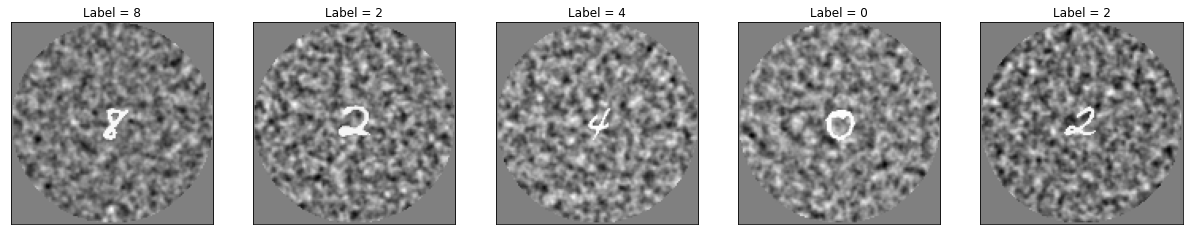

In [7]:
data = view_dataset(train_loader, n=5)

In [8]:
#data.savefig("../figures/data_128x128_noisy_no_shift_.png")

# Spatial transformer

In [9]:
class STN_128x128(nn.Module):

    def __init__(self):
        super(STN_128x128, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.conv3 = nn.Conv2d(50, 80, kernel_size=5)
        self.conv4 = nn.Conv2d(80, 100, kernel_size=5)
        self.fc1 = nn.Linear(100*4*4, 500)
        self.fc2 = nn.Linear(500, 10)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(10, 16, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)   
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(16 * 12 * 12, 32), #64
            nn.ReLU(True),
            #nn.Linear(64, 32),
            #nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)

        xs = xs.view(-1, 16 * 12 * 12)

        theta = self.fc_loc(xs)
        # resizing theta
        theta = theta.view(-1, 2, 3)
    
        # grid generator => transformation on parameter 

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 100*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.log_softmax(x, dim=1)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model = STN_128x128().to(device)

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * correct / len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

In [ ]:
args.epochs = 25
for epoch in range(1, args.epochs + 1):
    train(epoch, train_loader)
    test(test_loader)

Train Epoch: 1/60 [0/60000 (0%)]	Loss: 2.302663
Train Epoch: 1/60 [10000/60000 (17%)]	Loss: 2.302246
Train Epoch: 1/60 [20000/60000 (33%)]	Loss: 2.300804
Train Epoch: 1/60 [30000/60000 (50%)]	Loss: 2.302270
Train Epoch: 1/60 [40000/60000 (67%)]	Loss: 2.298132
Train Epoch: 1/60 [50000/60000 (83%)]	Loss: 2.303288

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

Train Epoch: 2/60 [0/60000 (0%)]	Loss: 2.300900
Train Epoch: 2/60 [10000/60000 (17%)]	Loss: 2.303729
Train Epoch: 2/60 [20000/60000 (33%)]	Loss: 2.299135
Train Epoch: 2/60 [30000/60000 (50%)]	Loss: 2.297021
Train Epoch: 2/60 [40000/60000 (67%)]	Loss: 2.298902
Train Epoch: 2/60 [50000/60000 (83%)]	Loss: 2.300916

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

Train Epoch: 3/60 [0/60000 (0%)]	Loss: 2.307263
Train Epoch: 3/60 [10000/60000 (17%)]	Loss: 2.302527
Train Epoch: 3/60 [20000/60000 (33%)]	Loss: 2.301837
Train Epoch: 3/60 [30000/60000 (50%)]	Loss: 2.293984
Train Epoch: 3/60 [40000/60000 (67%)]	Loss: 2


Test set: Average loss: 0.0008, Accuracy: 9731/10000 (97%)

Train Epoch: 23/60 [0/60000 (0%)]	Loss: 0.147590
Train Epoch: 23/60 [10000/60000 (17%)]	Loss: 0.127945
Train Epoch: 23/60 [20000/60000 (33%)]	Loss: 0.112196
Train Epoch: 23/60 [30000/60000 (50%)]	Loss: 0.036537
Train Epoch: 23/60 [40000/60000 (67%)]	Loss: 0.046331
Train Epoch: 23/60 [50000/60000 (83%)]	Loss: 0.154195

Test set: Average loss: 0.0007, Accuracy: 9772/10000 (98%)

Train Epoch: 24/60 [0/60000 (0%)]	Loss: 0.157726
Train Epoch: 24/60 [10000/60000 (17%)]	Loss: 0.025557
Train Epoch: 24/60 [20000/60000 (33%)]	Loss: 0.133017
Train Epoch: 24/60 [30000/60000 (50%)]	Loss: 0.048609
Train Epoch: 24/60 [40000/60000 (67%)]	Loss: 0.044792
Train Epoch: 24/60 [50000/60000 (83%)]	Loss: 0.062537

Test set: Average loss: 0.0008, Accuracy: 9733/10000 (97%)

Train Epoch: 25/60 [0/60000 (0%)]	Loss: 0.028646
Train Epoch: 25/60 [10000/60000 (17%)]	Loss: 0.064938
Train Epoch: 25/60 [20000/60000 (33%)]	Loss: 0.123644
Train Epoch: 25/60 [30

# Saving the model

In [62]:
PATH = "../models/stn_128x128_noshift.pt"
#torch.save(model, PATH)

# Loading the model

In [14]:
model = torch.load(PATH).to(device)+

# Taking a look at a few examples

In [86]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:25, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        data = data.type(torch.cuda.FloatTensor)
        
        output_tensor= model.stn(data)
        print(output_tensor.shape)

        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor, nrow=5))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor, nrow=5))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        #f.savefig('../figures/preliminary_128x128.png')

torch.Size([25, 1, 128, 128])


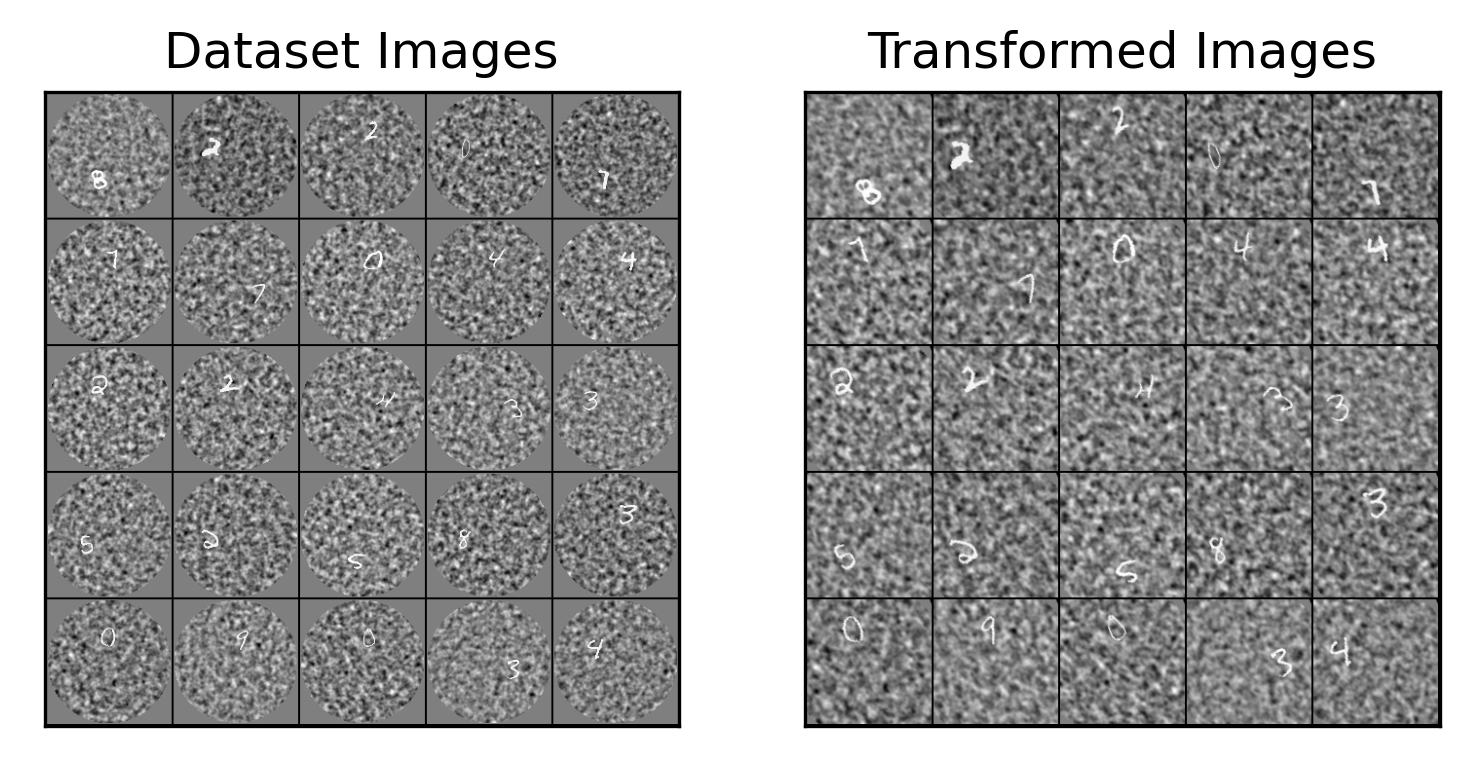

In [87]:
visualize_stn()

# Eccentricity

- Initialize radius=eccentricity in whereshift

In [34]:
args.offset_max = 40 #like in the paper
eccentricities = np.linspace(args.offset_max, 0, N_eccentricities, endpoint=False)
eccentricities

array([40.        , 35.55555556, 31.11111111, 26.66666667, 22.22222222,
       17.77777778, 13.33333333,  8.88888889,  4.44444444])

In [ ]:
"""for contrast in (0.3, 0.5, 0.7):
    args.contrast = contrast